# Train a regression ConvNN model using BOHB tuner

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from predict_observational_dataset_v3 import ProcessObservationalDataset, ObsParameterPredictor
from train_regression_2 import TrainRegression
from functions import *

# from functions import plot_predicted_vs_observed, boxplot_hist, plot_spectra_errorbar, plot_predicted_vs_spectra_errorbar
# from functions import filter_dataframe, interpolate_df, find_nearest_top_bottom, filter_dataset_range, regression_report, print_results_fun


2023-07-13 10:20:30.911601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

# Step 1: Load the dataset

In [2]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [3]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


In [4]:
df.iloc[::10]

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.00,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
10,5.00,1100,0.25,1.7,8.540979e-09,9.610928e-09,8.362026e-09,6.331807e-09,5.411898e-09,3.597492e-09,...,2.589948e-09,1.400508e-09,1.423739e-09,1.331622e-09,5.718932e-10,2.525684e-09,2.577776e-09,2.171606e-09,1.170498e-09,no
20,5.00,1100,0.50,1.0,2.089233e-08,2.547443e-08,2.398659e-08,1.954245e-08,1.673706e-08,1.128757e-08,...,1.030422e-08,6.744711e-09,6.570654e-09,5.994584e-09,3.266539e-09,6.722988e-09,6.756289e-09,5.708415e-09,3.422240e-09,no
30,5.00,1100,1.00,0.5,3.773544e-08,4.306029e-08,3.789344e-08,2.982717e-08,2.555826e-08,1.704151e-08,...,3.370933e-08,2.475817e-08,2.292027e-08,2.084380e-08,1.293259e-08,1.818421e-08,1.723477e-08,1.401317e-08,8.880054e-09,no
40,5.00,1100,1.50,0.0,7.403044e-08,8.240733e-08,7.323895e-08,5.885655e-08,5.086389e-08,3.452053e-08,...,1.067845e-07,8.506743e-08,7.629151e-08,6.833675e-08,4.665959e-08,5.297000e-08,4.829532e-08,3.887601e-08,2.587082e-08,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30840,3.25,1000,1.00,-1.0,6.179704e-08,6.023661e-08,4.317990e-08,3.128656e-08,2.771920e-08,1.748527e-08,...,6.074206e-08,4.763676e-08,4.974581e-08,4.320090e-08,2.942153e-08,4.588604e-08,4.660016e-08,3.899730e-08,2.401752e-08,no
30850,3.25,1000,1.00,1.7,4.587650e-09,3.838308e-09,2.586146e-09,1.860407e-09,1.635306e-09,1.152218e-09,...,1.364340e-09,8.768095e-10,8.903187e-10,7.791423e-10,4.586279e-10,1.281345e-09,9.366753e-10,5.737637e-10,3.020979e-10,no
30860,3.25,1000,1.50,1.0,9.151923e-09,7.599074e-09,4.870096e-09,3.395405e-09,2.993091e-09,2.001870e-09,...,8.316857e-09,5.922216e-09,5.734787e-09,5.036230e-09,3.292385e-09,4.859911e-09,3.820969e-09,2.376922e-09,1.196810e-09,no
30870,3.25,1000,2.00,0.5,1.755109e-08,1.456820e-08,9.125922e-09,6.253583e-09,5.540055e-09,3.570220e-09,...,3.041929e-08,2.417082e-08,2.437794e-08,2.183006e-08,1.552078e-08,1.638151e-08,1.205167e-08,7.349473e-09,3.697040e-09,no


## Prepare feature variables (X) and targets (y)

In [5]:
df = df[df['is_augmented'].isin(['no'])]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [6]:
y['temperature'] = np.log10(y['temperature'])

/tmp/ipykernel_21738/3354840019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['temperature'] = np.log10(y['temperature'])


In [7]:
# print( 'skewness:' )
# display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
# y.hist(grid=True, bins=19);

In [8]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Data Processing

In [11]:
# Create an instance of TrainCNNRegression
train_cnn_regression = TrainRegression(feature_values=X,
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

In [12]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [13]:
# normalize the X features using MinMax Scaler
train_cnn_regression.standardize_X_row_wise()

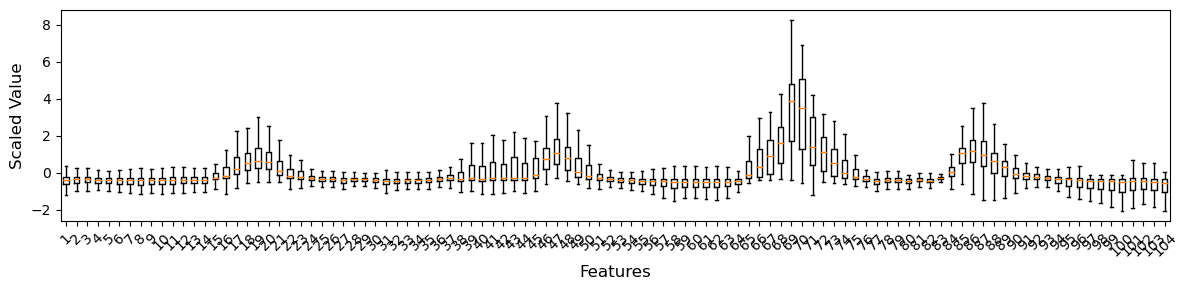

In [14]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_train_standardized_rowwise, xticks_list = None)

In [15]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

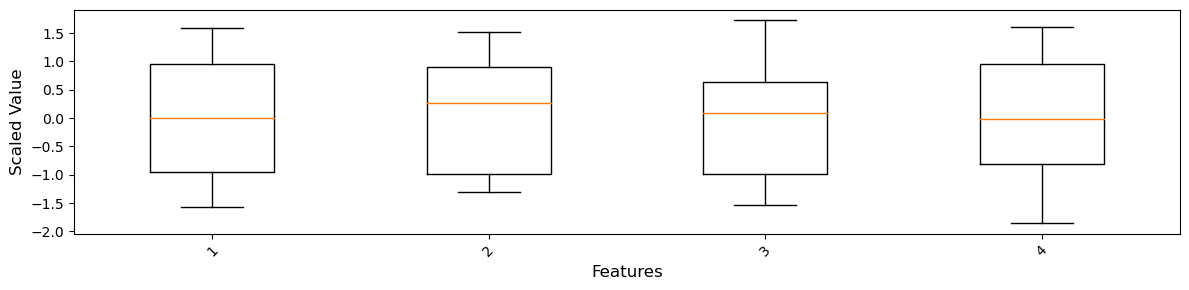

In [16]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.y_train_standardized_columnwise)

In [17]:
# train_cnn_regression.y_train_standardized_columnwise

In [18]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [19]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [20]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [21]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [22]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [23]:
df_MinMax_train.head()

,min,max
28744,8.265340e-12,3.445259e-08
6288,8.080712e-22,8.397132e-14
13749,2.734403e-07,8.632182e-06
11713,4.414951e-16,3.373262e-10
15538,3.722576e-07,6.859888e-06


In [24]:
# plt.loglog(train_cnn_regression.X_train_max, 'k.', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train, 'r.', label='X_train', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train_min, 'r.', alpha = 0.4)

---

In [25]:
train_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

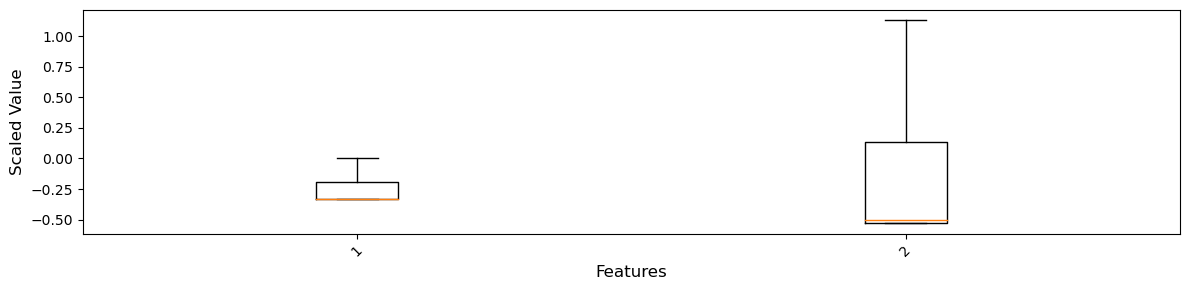

In [26]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_test_standardized_columnwise)

# Step 3: Load the Trained CNN model

## Load Saved Models

In [9]:
model = load_model('../../outputs/trained_models/my_model_architecture__xStand_yStand_MinMax_v2.h5')
model.load_weights('../../outputs/trained_models/my_model_weights__xStand_yStand_MinMax_v2.h5')

# Loading the saved history object
with open('../../outputs/trained_models/training_history__xStand_yStand_MinMax_v2.pkl', 'rb') as file:
    history = pk.load(file)    

2023-07-13 09:53:24.350509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 09:53:24.381724: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

# Step 4: Check Trained Model

---

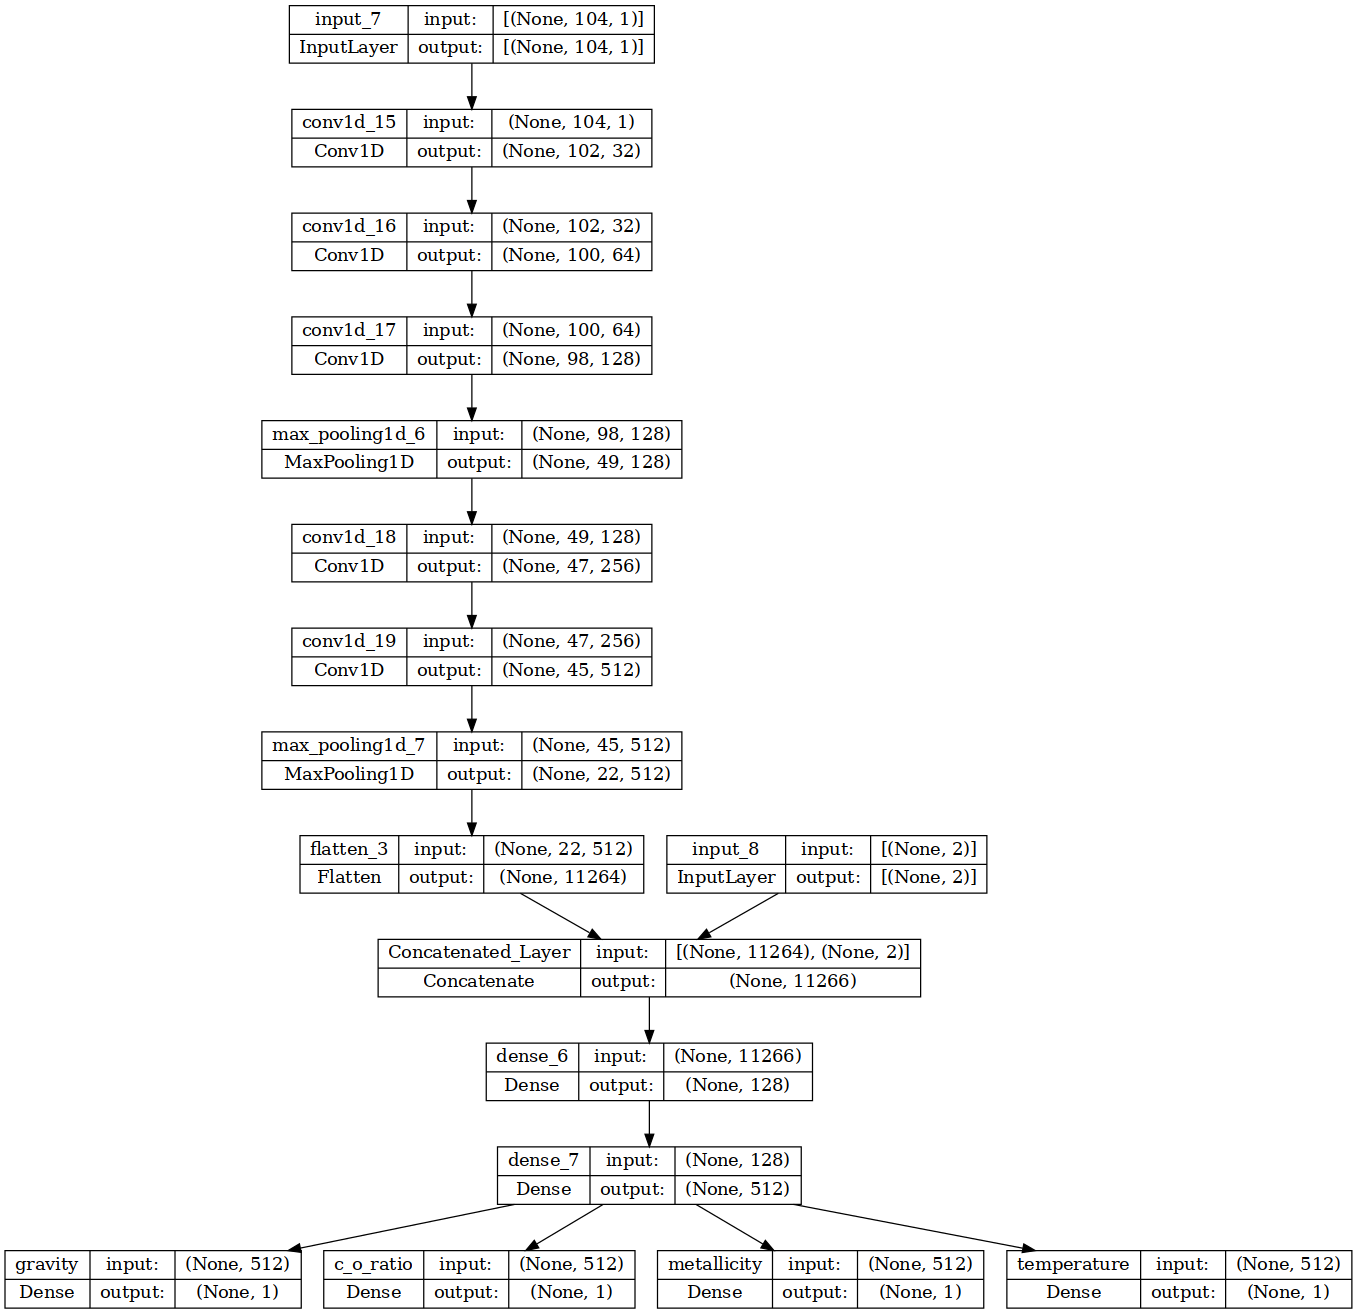

In [28]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
                show_layer_activations=False,
)

In [29]:
train_cnn_regression.trained_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 104, 1)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 102, 32)      128         ['input_7[0][0]']                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 100, 64)      6208        ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_17 (Conv1D)             (None, 98, 128)      24704       ['conv1d_16[0][0]']              
                                                                                            

In [30]:
train_cnn_regression.plot_model_loss(title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot Y predicted vs Y_Actual: Histogram & Scatter plot

6/6 [==============================] - 2s 375ms/step


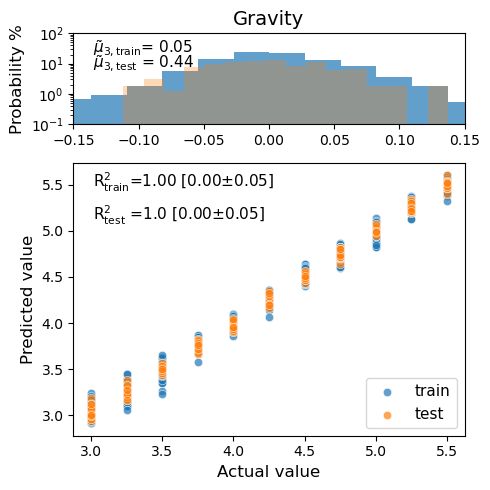

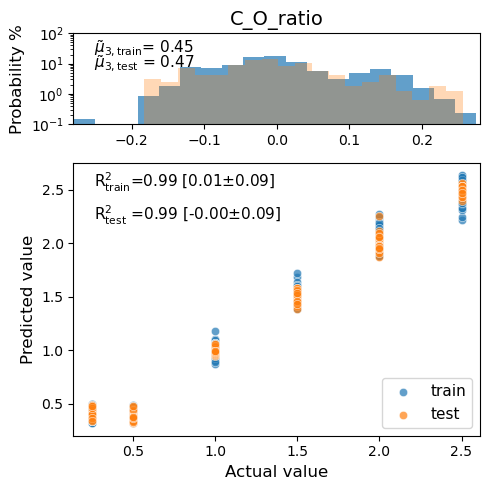

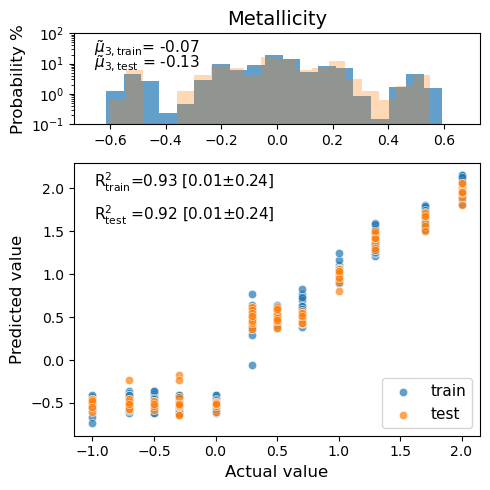

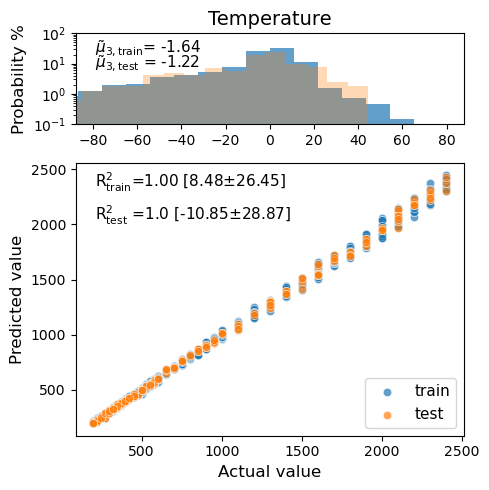

In [31]:
i = 19
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_standardized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_standardized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

# Step 5: Predict Observational data using the trained model

## ROSS 458C

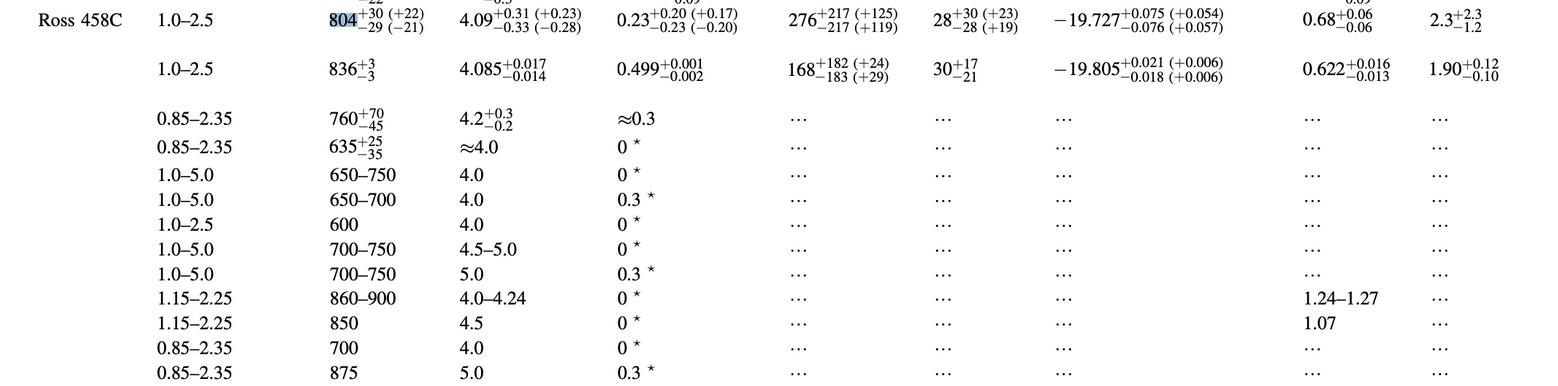

---

In [32]:
predict = ObsParameterPredictor(object_name = 'GJ570D', #Ross458C, HD3651B, GJ570D
                                                 dataset = df,
                                                 wl = wl, 
                                                 train_cnn_regression_class = train_cnn_regression,)

In [33]:
predict.load_observational_spectra()

Loading BokehJS ...

In [34]:
predict.obs_data

,wl,F_lambda,F_lambda_error
0,0.657971,4.569383e-17,7.119990e-17
1,0.660155,4.581152e-17,0.000000e+00
2,0.662332,4.592921e-17,0.000000e+00
3,0.664501,4.604690e-17,0.000000e+00
4,0.666665,4.616459e-17,8.804178e-17
...,...,...,...
555,2.548700,6.909362e-17,0.000000e+00
556,2.551630,7.652011e-17,6.939810e-17
557,2.554570,5.767152e-17,0.000000e+00
558,2.557520,3.882293e-17,0.000000e+00


In [35]:
predict.Process_Observational_Dataset()

******************************

Predicted Targets:
{   'c_o_ratio': 1.8205943,
    'gravity': 5.4260926,
    'metallicity': -0.39295313,
    'temperature': 824.2813}
******************************

[5.25, 5.5] [1.8205943] [800, 850] [-0.5, -0.3]


/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:314: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:390: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../teles

,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.933,0.924,0.915,0.906,0.897,gravity,metallicity,c_o_ratio,temperature,is_augmented
0,1.549801e-08,1.841079e-08,1.731954e-08,1.210810e-08,9.012371e-09,5.509706e-09,4.079047e-09,2.454497e-09,5.378183e-09,2.996622e-09,...,5.640913e-09,8.124181e-09,7.076882e-09,5.285473e-09,3.070505e-09,5.426093,-0.392953,1.820594,824.281311,no


,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
0,1.915624e-08,2.206102e-08,1.684466e-08,1.863393e-08,1.231363e-08,8.572828e-09,8.760881e-09,8.187037e-09,6.693866e-09,7.612835e-09,...,2.911763e-08,1.943760e-08,1.443783e-08,1.299396e-08,1.371097e-08,7.329417e-09,1.170489e-08,1.062637e-08,8.611113e-09,7.280711e-09


******************************

Predicted Targets:
{   'c_o_ratio': 1.8205943,
    'gravity': 5.4260926,
    'metallicity': -0.39295313,
    'temperature': 824.2813}
******************************



,logg,c_o,met,T
count,50.000000,50.000000,50.000000,50.000000
mean,5.274528,1.727811,-0.393846,795.462158
std,0.151527,0.136228,0.053705,25.500576
min,4.821874,1.357595,-0.482390,741.454529
25%,5.218484,1.645063,-0.432174,778.453171
50%,5.282766,1.725707,-0.397080,792.143738
75%,5.355852,1.833033,-0.369390,813.446075
max,5.569889,2.026788,-0.232376,856.982483


<Figure size 640x480 with 0 Axes>

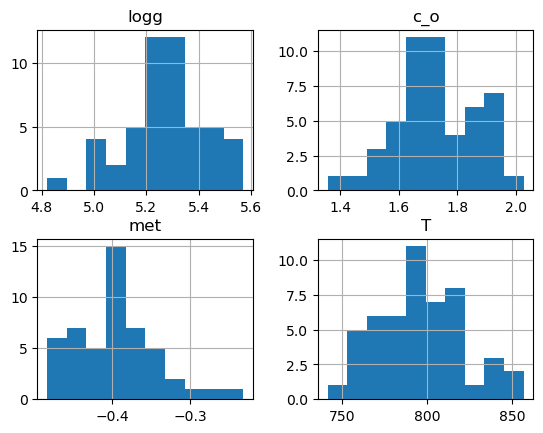

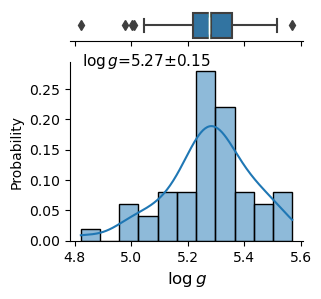

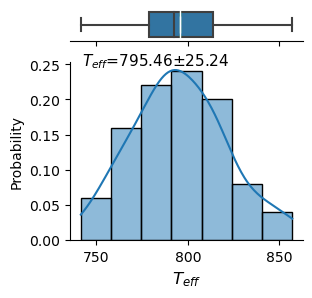

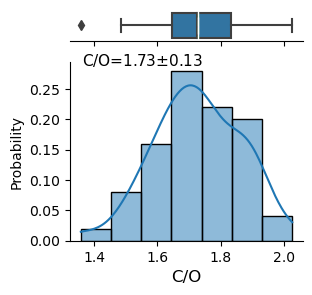

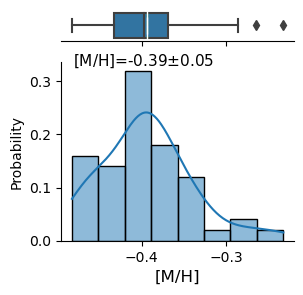

[5.25, 5.5] [1.7278114557266235] [750, 800] [-0.5, -0.3]


/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:314: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:390: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../teles

,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.933,0.924,0.915,0.906,0.897,gravity,metallicity,c_o_ratio,temperature,is_augmented
0,1.295261e-08,1.537574e-08,1.428134e-08,9.678673e-09,7.108292e-09,4.211223e-09,3.079507e-09,1.793591e-09,4.105007e-09,2.172446e-09,...,4.401232e-09,6.701174e-09,5.899990e-09,4.425187e-09,2.539129e-09,5.274528,-0.393846,1.727811,795.462158,no


,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
0,1.915624e-08,2.206102e-08,1.684466e-08,1.863393e-08,1.231363e-08,8.572828e-09,8.760881e-09,8.187037e-09,6.693866e-09,7.612835e-09,...,2.911763e-08,1.943760e-08,1.443783e-08,1.299396e-08,1.371097e-08,7.329417e-09,1.170489e-08,1.062637e-08,8.611113e-09,7.280711e-09


[5.25, 5.5] [1.7278114557266235] [750, 800] [-0.5, -0.3]


/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:314: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/functions.py:390: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../teles

,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.933,0.924,0.915,0.906,0.897,gravity,metallicity,c_o_ratio,temperature,is_augmented
0,1.295261e-08,1.537574e-08,1.428134e-08,9.678673e-09,7.108292e-09,4.211223e-09,3.079507e-09,1.793591e-09,4.105007e-09,2.172446e-09,...,4.401232e-09,6.701174e-09,5.899990e-09,4.425187e-09,2.539129e-09,5.274528,-0.393846,1.727811,795.462158,no


,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
0,1.915624e-08,2.206102e-08,1.684466e-08,1.863393e-08,1.231363e-08,8.572828e-09,8.760881e-09,8.187037e-09,6.693866e-09,7.612835e-09,...,2.911763e-08,1.943760e-08,1.443783e-08,1.299396e-08,1.371097e-08,7.329417e-09,1.170489e-08,1.062637e-08,8.611113e-09,7.280711e-09


Loading BokehJS ...

,confidence_level_lower,confidence_level_upper,mean,std_values,wl
2.511960,7.253597e-09,8.296031e-09,7.774814e-09,1.834001e-09,2.511960
2.486966,8.561974e-09,9.036199e-09,8.799087e-09,8.343251e-10,2.486966
2.462220,1.022976e-08,1.103451e-08,1.063213e-08,1.415834e-09,2.462220
2.437720,1.132337e-08,1.198893e-08,1.165615e-08,1.170953e-09,2.437720
2.413464,6.931499e-09,7.462640e-09,7.197070e-09,9.344588e-10,2.413464
...,...,...,...,...,...
0.933378,1.347835e-08,1.516502e-08,1.432168e-08,2.967443e-09,0.933378
0.924091,2.024326e-08,2.190210e-08,2.107268e-08,2.918471e-09,0.924091
0.914896,1.794974e-08,2.028743e-08,1.911858e-08,4.112793e-09,0.914896
0.905792,2.737564e-08,3.180641e-08,2.959102e-08,7.795243e-09,0.905792


In [36]:
predict.predict_from_random_spectra(random_spectra_num= 50,
                                    print_results_= True,
                                    plot_randomly_generated_spectra__= True,
                                    plot_histogram_= True,
                                    plot_boxplot_hist_= True,
                                    plot_predicted_vs_observed_= True,
                                    plot_predicted_vs_spectra_errorbar_= True,
                                    plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar_ = True,
                                    calculate_confidence_intervals_std_df_=True,
                                    )

---

# END ------